In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
import os
import sys
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))
import random
from collections import defaultdict
import itertools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

from IPython.display import display, Markdown, Latex
from tqdm import tnrange

import torch
from torch import nn
import torch.nn.functional as F

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

In [3]:
torch.manual_seed(33)

In [4]:
from simple_relational_reasoning.datagen import *
from simple_relational_reasoning.models import MLPModel, RelationNetModel

import run
from defaults import FIELD_CONFIGURATIONS

In [5]:
FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save_plot(save_path, bbox_inches='tight'):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        print('Figure:\n')
        print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
        print('\nWrapfigure:\n')
        print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
        print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [6]:
from collections import namedtuple
VisualizationDefinition = namedtuple('VisualizationDefinition', ('name', 'patch_class', 'offset', 'patch_args'))
VISUALIZATION_DEFINITIONS = (
    VisualizationDefinition('square', mpatches.Rectangle, np.array([0, 0]), (10, 10)),
    VisualizationDefinition('circle', mpatches.Ellipse, np.array([5, 5]), (10, 10)),
    VisualizationDefinition('triangle', mpatches.RegularPolygon, np.array([5, 5]), (3, 6)),
    VisualizationDefinition('pentagon', mpatches.RegularPolygon, np.array([5, 5]), (5, 5.5)),
)


DEFAULT_PATCH_KWARGS = dict(ec='none')
DEFAULT_SCALE = 10


def object_to_patch(object_tensor, field_slices, 
                    x_field='x', y_field='y', 
                    x_length_field='x_len', y_length_field='y_len',
                    color_field='color', shape_field='shape',
                    scale=DEFAULT_SCALE, additional_patch_kwargs=None, 
                    visualization_definitions=VISUALIZATION_DEFINITIONS):
    
    patch_kwargs = DEFAULT_PATCH_KWARGS.copy()
    if additional_patch_kwargs is not None: 
        patch_kwargs.update(additional_patch_kwargs)
    
    x = int(object_tensor[field_slices[x_field]])
    y = int(object_tensor[field_slices[y_field]])
    position = np.array([x, y]) * scale
    
    shape_index = 0
    if shape_field in field_slices:
        shape_index = int(torch.nonzero(object_tensor[field_slices[shape_field]]).squeeze())
        
    color_index = 0
    if color_field in field_slices:
        color_index = int(torch.nonzero(object_tensor[field_slices[color_field]]).squeeze())
        
    
    vis_def = visualization_definitions[shape_index]
    offset = vis_def.offset
    patch_args = vis_def.patch_args
    
    x_len = 1
    if x_length_field in field_slices:
        x_len = object_tensor[field_slices[x_length_field]]
        
    y_len = 1
    if y_length_field in field_slices:
        y_len = object_tensor[field_slices[y_length_field]]
        
    offset = np.multiply(offset, np.array([x_len, y_len]))
    patch_args = [patch_args[0] * x_len, patch_args[1] * y_len] + list(patch_args[2:])
    
    patch = vis_def.patch_class(position + offset, *patch_args, **patch_kwargs)
    
    return patch, color_index


def visualize_objects(objects, object_generator, ax=None, x_field='x',
                      y_field='y', color_field='color', shape_field='shape',
                      scale=DEFAULT_SCALE, figsize=(6, 6), bg_color='black', 
                      additional_patch_kwargs=None, 
                      visualization_definitions=VISUALIZATION_DEFINITIONS,
                      cmap=plt.cm.tab10, clim=(0, 10)):
   
    call_show = False
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
        call_show = True

    x_gen = object_generator.field_generators[x_field]
    plt.xlim(x_gen.min_coord * scale, x_gen.max_coord * scale)
    y_gen = object_generator.field_generators[y_field]
    plt.ylim(y_gen.min_coord * scale, y_gen.max_coord * scale)
    ax.set_facecolor(bg_color)
    
    patches, colors = zip(*[object_to_patch(objects[i], object_generator.field_slices, 
                                            x_field=x_field, y_field=y_field, 
                                            color_field=color_field, shape_field=shape_field, 
                                            scale=scale, additional_patch_kwargs=additional_patch_kwargs,
                                            visualization_definitions=visualization_definitions)
                            for i in range(objects.shape[0])])
    
    collection = PatchCollection(patches, cmap=cmap) 
    collection.set_array(np.array(colors)) 
    collection.set_edgecolor('white')
    collection.set_clim(*clim)
    ax.add_collection(collection)
    
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    if call_show:
        plt.show()
    

In [7]:
QUINN_FIELD_CONFIG_WITH_SIZE = (
    object_gen.FieldConfig('x', 'int_position', dict(max_coord=20)),
    object_gen.FieldConfig('y', 'int_position', dict(max_coord=20)),
    object_gen.FieldConfig('x_len', 'int_position', dict(min_coord=1, max_coord=10)),
    object_gen.FieldConfig('color', 'one_hot', dict(n_types=2)),
)
QUINN_FAUX_GENERATOR_WITH_SIZE = ObjectGenerator(1, QUINN_FIELD_CONFIG_WITH_SIZE, BetweenRelation)

QUINN_FIELD_CONFIG_WITHOUT_SIZE = (
    object_gen.FieldConfig('x', 'int_position', dict(max_coord=20)),
    object_gen.FieldConfig('y', 'int_position', dict(max_coord=20)),
    object_gen.FieldConfig('color', 'one_hot', dict(n_types=2)),
)

QUINN_FAUX_GENERATOR_WITHOUT_SIZE = ObjectGenerator(1, QUINN_FIELD_CONFIG_WITHOUT_SIZE, BetweenRelation)

FAUX_GENERATORS = {
    ObjectGeneratorWithoutSize: QUINN_FAUX_GENERATOR_WITHOUT_SIZE,
    ObjectGeneratorWithSize: QUINN_FAUX_GENERATOR_WITH_SIZE
}

above vs. below using objects without size
Of the reference object locations, train: 273, test: 31 
Training set size: 5733 | Test set without middle: 1650 | Middle set size: 5472


<ipython-input-6-e3607ab0222c>:36: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629449223/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  color_index = int(torch.nonzero(object_tensor[field_slices[color_field]]).squeeze())


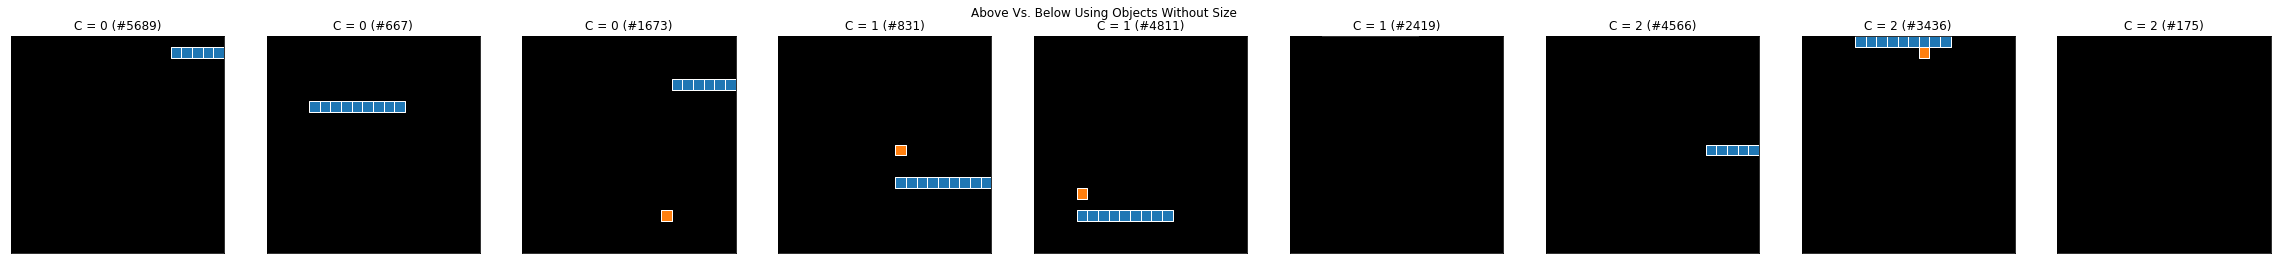

above vs. below using objects with size
Of the reference object locations, train: 273, test: 31 
Training set size: 5733 | Test set without middle: 1650 | Middle set size: 5472


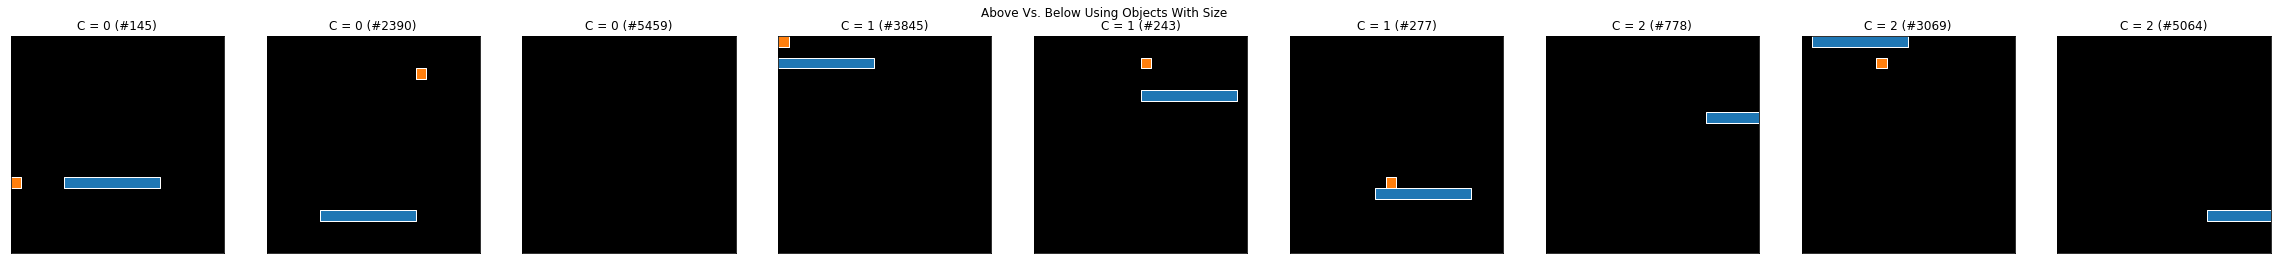

above vs. below vs. between using objects without size
Of the reference object locations, train: 216, test: 24 
Training set size: 6048 | Test set without middle: 1944 | Middle set size: 6480


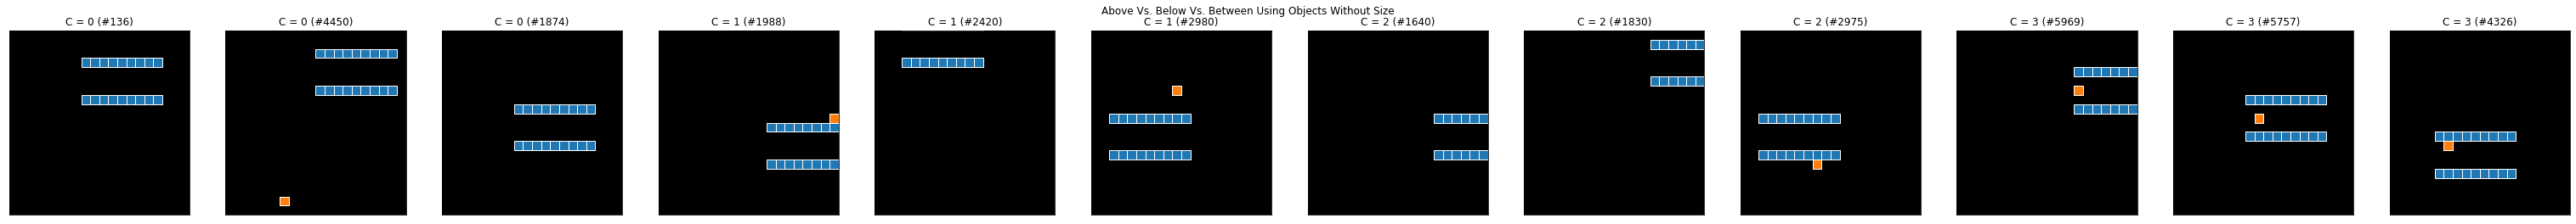

above vs. below vs. between using objects with size
Of the reference object locations, train: 216, test: 24 
Training set size: 6048 | Test set without middle: 1944 | Middle set size: 6480


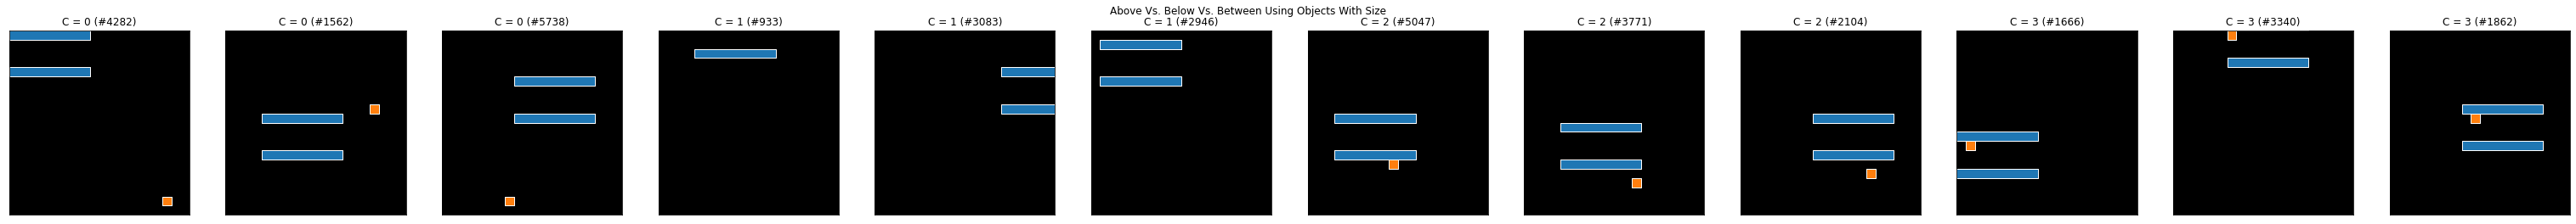

In [8]:
REFERENCE_OBJECT_SIZE = 9
TARGET_OBJECT_SIZE = 1
ADD_NEITHER = True
X_MAX = 25
Y_MAX = 25
SEED = 33
PROP_TRAIN_REF_LOCATIONS = 0.90
N_TRAIN_TARGET_OBJECT_LOCATIONS = 7


EXAMPLES_PER_CLASS = 3

NAMES = {
    AboveBelowReferenceInductiveBias: 'above vs. below',
    BetweenReferenceInductiveBias: 'above vs. below vs. between',
    ObjectGeneratorWithoutSize: 'objects without size',
    ObjectGeneratorWithSize: 'objects with size'
}

DATASETS = {}


for dataset_class in (AboveBelowReferenceInductiveBias, BetweenReferenceInductiveBias):
    for generator_class in (ObjectGeneratorWithoutSize, ObjectGeneratorWithSize):
        title = f'{NAMES[dataset_class]} using {NAMES[generator_class]}'
        print(title)
        gen = generator_class(SEED, REFERENCE_OBJECT_SIZE, TARGET_OBJECT_SIZE)
        dataset = dataset_class(gen, X_MAX, Y_MAX, SEED, prop_train_reference_object_locations=PROP_TRAIN_REF_LOCATIONS,
                               n_train_target_object_locations=N_TRAIN_TARGET_OBJECT_LOCATIONS)
        
        DATASETS[(dataset_class, generator_class)] = dataset
        
        train = dataset.get_training_dataset()
        label_arr = np.array(train.labels)
        unique_labels, unique_counts = np.unique(label_arr, return_counts=True)
#         print(len(train), unique_labels, unique_counts)
        
        test_datasets = dataset.get_test_datasets()
#         print([(key, len(test_datasets[key])) for key in test_datasets])
        
        test_without_middle_size = sum([len(test_datasets[key]) for key in test_datasets if 'middle' not in key]) 
        test_middle_size = sum([len(test_datasets[key]) for key in test_datasets if 'middle' in key])
        
        print(f'Of the reference object locations, train: {len(dataset.train_reference_object_locations)}, test: {len(dataset.test_reference_object_locations)} ')
        
        print(f'Training set size: {len(train)} | Test set without middle: {test_without_middle_size} | Middle set size: {test_middle_size}')
        
        n_labels = len(unique_labels)
        n_panels = n_labels * EXAMPLES_PER_CLASS
        plt.figure(figsize=(4.5 * n_panels, 4))
        plt.suptitle(title.title())
        
        for l_i, label in enumerate(unique_labels):
            indices = np.random.permutation(np.argwhere(label_arr == label))[:EXAMPLES_PER_CLASS].squeeze()
            for ex_i, ex in enumerate(indices):
                ax = plt.subplot(1, n_panels, 1 + (l_i * EXAMPLES_PER_CLASS) + ex_i)
                ax.set_title(f'C = {label} (#{ex})')
                visualize_objects(train[ex][0], FAUX_GENERATORS[generator_class], ax=ax)
            
        plt.show()

In [ ]:
REFERENCE_OBJECT_SIZE = 9
TARGET_OBJECT_SIZE = 1
ADD_NEITHER = True
X_MAX = 18
Y_MAX = 18
SEED = 33
EXAMPLES_PER_CLASS = 4
PROP_TRAIN_REF_LOCATIONS = 0.90
PROP_TRAIN_TARGET_LOCATIONS = 0.75

indices = {}

ONE_OR_TWO_DATASETS = {}


for generator_class in (ObjectGeneratorWithoutSize, ObjectGeneratorWithSize):
    for two_reference_objects in (False, True):
        title = f'{two_reference_objects and "Two reference objects" or "One reference object"} using {NAMES[generator_class]}'
        print(title)
        gen = generator_class(SEED, REFERENCE_OBJECT_SIZE, TARGET_OBJECT_SIZE)
        dataset = OneOrTwoReferenceObjects(gen, X_MAX, Y_MAX, SEED, two_reference_objects=two_reference_objects,
                                           prop_train_reference_object_locations=PROP_TRAIN_REF_LOCATIONS,
                                           prop_train_target_object_locations=PROP_TRAIN_TARGET_LOCATIONS)
        
        ONE_OR_TWO_DATASETS[generator_class, two_reference_objects] = dataset
        
        train = dataset.get_training_dataset()
        label_arr = np.array(train.labels)
        unique_labels, unique_counts = np.unique(label_arr, return_counts=True)
#         print(len(train), unique_labels, unique_counts)
        
        test_datasets = dataset.get_test_datasets()
#         print([(key, len(test_datasets[key])) for key in test_datasets])

        print(f'Of the reference object locations, train: {len(dataset.train_reference_object_locations)}, test: {len(dataset.test_reference_object_locations)} ')

        total_test_size = sum([len(test_datasets[key]) for key in test_datasets]) 
        print(f'Training set size: {len(train)} | Test set size: {total_test_size}')
        
        n_labels = len(unique_labels)
        n_panels = n_labels * EXAMPLES_PER_CLASS
        plt.figure(figsize=(4.5 * n_panels, 4))
        plt.suptitle(title.title())
        
        for l_i, label in enumerate(unique_labels):
            if label not in indices:
                indices[label] = np.random.permutation(np.argwhere(label_arr == label))[:EXAMPLES_PER_CLASS].squeeze()
                
            for ex_i, ex in enumerate(indices[label]):
                ax = plt.subplot(1, n_panels, 1 + (l_i * EXAMPLES_PER_CLASS) + ex_i)
                ax.set_title(f'C = {label_arr[ex]} (#{ex})')
                visualize_objects(train[ex][0], FAUX_GENERATORS[generator_class], ax=ax)
            
        plt.show()
        
    indices = {}

In [ ]:
for seed in range(100, 200):
    if seed % 10 == 0:
        print(seed)
        
    for dataset_class in (AboveBelowReferenceInductiveBias, BetweenReferenceInductiveBias):
        for generator_class in (ObjectGeneratorWithoutSize, ObjectGeneratorWithSize):
            for add_neither in (False, True):
                title = f'{NAMES[dataset_class]} using {NAMES[generator_class]}'
                gen = generator_class(seed, REFERENCE_OBJECT_SIZE, TARGET_OBJECT_SIZE)
                dataset = dataset_class(gen, X_MAX, Y_MAX, seed, prop_train_reference_object_locations=PROP_TRAIN_REF_LOCATIONS,
                                       n_train_target_object_locations=N_TRAIN_TARGET_OBJECT_LOCATIONS,
                                       add_neither_train=add_neither, add_neither_test=add_neither)

                train = dataset.get_training_dataset()
                if train.objects.max() > 24:
                    print(seed, dataset_class, generator_class, add_neither)
                    break
                    
                for test_key, test_set in dataset.get_test_datasets().items():
                    if test_set.objects.max() > 24:
                        print(seed, dataset_class, generator_class, add_neither, test_key)
                        break
                        
                spatial_dataset = dataset_class(gen, X_MAX, Y_MAX, seed, prop_train_reference_object_locations=PROP_TRAIN_REF_LOCATIONS,
                                       n_train_target_object_locations=N_TRAIN_TARGET_OBJECT_LOCATIONS,
                                       add_neither_train=add_neither, add_neither_test=add_neither, spatial_dataset=True)

                spatial_train = spatial_dataset.get_training_dataset()
                if spatial_train.spatial_objects.max() > 24:
                    print('Spatial', seed, dataset_class, generator_class, add_neither)
                    break
                    
                for test_key, test_set in spatial_dataset.get_test_datasets().items():
                    if test_set.spatial_objects.max() > 24:
                        print('Spatial', seed, dataset_class, generator_class, add_neither, test_key)
                        break

100
110
120
130
140
150
160


In [ ]:
N = 10
START = 0

plt.figure(figsize=(4.5 * N, 4))

for i in range(10):
    ax = plt.subplot(1, N, i + 1)
    ax.set_title(f'C = {label} (#{ex})')
    visualize_objects(train[START + (i * 2)][0], FAUX_GENERATORS[generator_class], ax=ax)



In [ ]:
gen_with_size = ObjectGeneratorWithSize(9, 1)
above_below_dataset_size = AboveBelowReferenceInductiveBias(gen_with_size, 20, 20, 33)
train_dataset_size = above_below_dataset_size.get_training_dataset()
print(len(train_dataset_size))
test_datasets_size = above_below_dataset_size.get_test_datasets()
print([(key, len(test_datasets_size[key])) for key in test_datasets_size])

In [ ]:
visualize_objects(train_dataset_size[12][0], QUINN_FAUX_GENERATOR_WITH_SIZE)

In [ ]:
np.unique(train_dataset.labels, return_counts=True)

In [ ]:
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)    
    visualize_objects(generate_above(gen), gen, ax=ax)

In [ ]:
X = {}
y = {}
object_generators = {}
positive_indices = {}
negative_indices = {}

for num_objects in (5, 10):
    
    for i, relation in enumerate(run.RELATION_NAMES_TO_CLASSES):
        key = (num_objects, relation)
        
        relation_class = run.RELATION_NAMES_TO_CLASSES[relation]
        object_generator = object_gen.SmartBalancedBatchObjectGenerator(
            num_objects, run.FIELD_CONFIGURATIONS['default'], relation_class)
        object_generators[key] = object_generator
            
        X[key], y[key] = object_generator(100)
        y[key] = y[key].bool()
        
        positive_indices[key] = torch.nonzero(y[key]).squeeze()
        negative_indices[key] = torch.nonzero(~y[key]).squeeze()
                   


In [ ]:
NUM_ROWS = 2
NUM_RELATIONS = len(run.RELATION_NAMES_TO_CLASSES)
FONTSIZE = 16

pos_idx_choices = defaultdict(lambda: 0)
neg_idx_choices = defaultdict(lambda: 0)

pos_idx_choices[(5, 'above')] = 1
pos_idx_choices[(5, 'count')] = 1

for num_objects in (5, 10):
    fig = plt.figure(figsize=(12, 6))
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    
    for i, relation in enumerate(run.RELATION_NAMES_TO_CLASSES):
        key = (num_objects, relation)
            
        pos_idx = positive_indices[key][pos_idx_choices[key]]
        neg_idx = negative_indices[key][neg_idx_choices[key]]
    
        pos_ax = plt.subplot(NUM_ROWS, NUM_RELATIONS, i + 1)
        if i == 0:
            pos_ax.set_ylabel('Positive Examples', fontsize=FONTSIZE)
        visualize_objects(X[key][pos_idx], object_generators[key], pos_ax)
        pos_ax.set_title(relation.title(), fontsize=FONTSIZE)
    
        neg_ax = plt.subplot(NUM_ROWS, NUM_RELATIONS, NUM_RELATIONS + i + 1)
        if i == 0:
            neg_ax.set_ylabel('Negative Examples', fontsize=FONTSIZE)
        visualize_objects(X[key][neg_idx], object_generators[key], neg_ax)
    
#     save_plot(f'example_images_{num_objects}.pdf')
        
    plt.show()


# Taking a stab at the Quinn-like relations

In [ ]:
def to_one_hot(arr):
    one_hot = np.zeros((arr.size, int(max(arr) + 1)))
    one_hot[np.arange(arr.size), arr] = 1
    return one_hot


def generate_above(object_generator, line_length=4, 
                   x_field='x', y_field='y', color_field='color', shape_field='shape',):
    x_gen = object_generator.field_generators[x_field]
    y_gen = object_generator.field_generators[y_field]
    
    line_x_start = np.random.randint(0, x_gen.max_coord - line_length)
    line_x_end = line_x_start + line_length  # exclusive
    line_y = np.random.randint(0, y_gen.max_coord - 1)
        
    target_x = np.random.randint(line_x_start, line_x_end)
    target_y = np.random.randint(line_y + 1, min(line_y + 3, y_gen.max_coord))
    
    line_color = np.random.randint(0, 2)
    target_color = 1 - line_color
    shape = np.random.randint(0, 2)
    
    x = np.expand_dims(np.append(np.arange(line_x_start, line_x_end), target_x), -1)
    y = np.expand_dims(np.append(np.repeat(line_y, line_length), target_y), -1)
    color = to_one_hot(np.append(np.repeat(line_color, line_length), target_color))
    shape = to_one_hot(np.repeat(shape, line_length + 1))
    
    return torch.from_numpy(np.concatenate((x, y, color, shape), axis=-1)).to(torch.float)



fig = plt.figure(figsize=(16, 4))
plt.subplots_adjust(hspace=0.1, wspace=0.1)

gen = list(object_generators.values())[0]

for i in range(4):
    ax = plt.subplot(1, 4, i + 1)    
    visualize_objects(generate_above(gen), gen, ax=ax)

In [ ]:
field_config_with_length = (
    object_gen.FieldConfig('x', 'int_position', dict(max_coord=16)),
    object_gen.FieldConfig('y', 'int_position', dict(max_coord=16)),
    object_gen.FieldConfig('x_len', 'int_position', dict(min_coord=1, max_coord=4)),
    object_gen.FieldConfig('y_len', 'int_position', dict(min_coord=1, max_coord=4)),
    object_gen.FieldConfig('color', 'one_hot', dict(n_types=2)),
    object_gen.FieldConfig('shape', 'one_hot', dict(n_types=2))
)

gen_with_length = ObjectGenerator(2, field_config_with_length, MultipleDAdjacentRelation)


def generate_above_with_length(object_generator, line_length=4, 
                   x_field='x', y_field='y', color_field='color', shape_field='shape',):
    x_gen = object_generator.field_generators[x_field]
    y_gen = object_generator.field_generators[y_field]
    
    line_x_start = np.random.randint(0, x_gen.max_coord - line_length)
    line_y = np.random.randint(0, y_gen.max_coord - 1)
        
    target_x = np.random.randint(line_x_start, line_x_start + line_length)
    target_y = np.random.randint(line_y + 1, min(line_y + 3, y_gen.max_coord))
    
    line_color = np.random.randint(0, 2)
    target_color = 1 - line_color
    shape = np.random.randint(0, 2)
    
    x = np.expand_dims(np.array([line_x_start, target_x]), -1)
    y = np.expand_dims(np.array([line_y, target_y]), -1)
    x_len = np.expand_dims(np.array([line_length, 1]), -1)
    y_len = np.expand_dims(np.array([1, 1]), -1)
    color = to_one_hot(np.array([line_color, target_color]))
    shape = to_one_hot(np.repeat(shape, 2))
    
    return torch.from_numpy(np.concatenate((x, y, x_len, y_len, color, shape), axis=-1)).to(torch.float)


fig = plt.figure(figsize=(16, 4))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    visualize_objects(generate_above_with_length(gen_with_length), gen_with_length, ax=ax)

## Questions:
* Do we want distractor objects?
* How much position variation do we want? In other words, if the line is 4 units long, what should the length of the entire axis be?
* What do we train on, and what do we test on?
* Do we need more than two colors and shapes?
* Do we want variation in the distance between the objects, too? Or should they always be adjacent? 
* **The positives are easy. What are the negatives?? What are the generalization tests??**
* **Come up with example stimuli for each of the different parts of the experiments**

# Equivalent of Figure 3.2 

In [ ]:
field_config_with_length = (
    object_gen.FieldConfig('x', 'int_position', dict(max_coord=20)),
    object_gen.FieldConfig('y', 'int_position', dict(max_coord=20)),
    object_gen.FieldConfig('x_len', 'int_position', dict(min_coord=1, max_coord=4)),
    object_gen.FieldConfig('y_len', 'int_position', dict(min_coord=1, max_coord=4)),
    object_gen.FieldConfig('color', 'one_hot', dict(n_types=3)),
    object_gen.FieldConfig('shape', 'one_hot', dict(n_types=2))
)

gen_with_length = ObjectGenerator(2, field_config_with_length, MultipleDAdjacentRelation)


def combine(*args):
    print([len(x) for x in args])
    arrays = []
    for arr in args:
        if len(arr.shape) == 1:
            arr = np.expand_dims(arr, -1)
        
        arrays.append(arr)
        
    return torch.from_numpy(np.concatenate(arrays, axis=-1)).to(torch.float)


def generate_3_2(object_generator, line_length=9, 
                   x_field='x', y_field='y', color_field='color', shape_field='shape',):
    x_gen = object_generator.field_generators[x_field]
    y_gen = object_generator.field_generators[y_field]
    
    line_x_start = np.random.randint(0, x_gen.max_coord - line_length)
    line_x_end = line_x_start + line_length
    line_y = np.random.randint(3, y_gen.max_coord - 4)
        
#     target_x = np.random.randint(line_x_start, line_x_start + line_length)
#     target_y = np.random.randint(line_y + 1, min(line_y + 3, y_gen.max_coord))

    above_x = np.arange(line_x_start, line_x_start + 3)
    above_y = np.arange(line_y + 1, line_y + 4)
    above_x_values, above_y_values = zip(*itertools.product(above_x, above_y))
    
    below_x = np.arange(line_x_end - 3, line_x_end)
    below_y = np.arange(line_y - 3, line_y)
    below_x_values, below_y_values = zip(*itertools.product(below_x, below_y))

    line_color = 0
    above_color = 1
    below_color = 2
    shape = 0
    
    x = np.array([line_x_start] + list(above_x_values) + list(below_x_values))
    y = np.array([line_y] + list(above_y_values) + list(below_y_values))
    x_len = np.array([line_length] + [1] * (len(above_x_values) + len(below_x_values)))
    y_len = np.repeat(1, 1 + len(above_y_values) + len(below_y_values)) 
    color = to_one_hot(np.array([line_color] + [above_color] * len(above_x_values) + [below_color] * len(below_x_values)))
    shape = to_one_hot(np.repeat(shape, 1 + len(above_y_values) + len(below_y_values)))
    
    return combine(x, y, x_len, y_len, color, shape)


fig = plt.figure(figsize=(16, 4))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    visualize_objects(generate_3_2(gen_with_length), gen_with_length, ax=ax)

# 3.3

In [ ]:
def generate_3_3(object_generator, line_length=9, 
                   x_field='x', y_field='y', color_field='color', shape_field='shape',):
    x_gen = object_generator.field_generators[x_field]
    y_gen = object_generator.field_generators[y_field]
    
    line_x_start = np.random.randint(0, x_gen.max_coord - line_length)
    line_x_end = line_x_start + line_length
    line_y = np.random.randint(3, y_gen.max_coord - 4)
        
#     target_x = np.random.randint(line_x_start, line_x_start + line_length)
#     target_y = np.random.randint(line_y + 1, min(line_y + 3, y_gen.max_coord))

    above_x = np.arange(line_x_start, line_x_start + 3)
    above_y = np.arange(line_y + 1, line_y + 4)
    above_x_values, above_y_values = zip(*itertools.product(above_x, above_y))
    
    below_x = np.arange(line_x_end - 3, line_x_end)
    below_y = np.arange(line_y - 3, line_y)
    below_x_values, below_y_values = zip(*itertools.product(below_x, below_y))

    line_color = 0
    above_color = 1
    below_color = 2
    shape = 0
    
    x = np.array(list(range(line_x_start, line_x_end)) + list(above_x_values) + list(below_x_values))
    y = np.array([line_y] * line_length + list(above_y_values) + list(below_y_values))
    x_len = np.array([1] * (line_length + len(above_x_values) + len(below_x_values)))
    y_len = np.repeat(1, line_length + len(above_y_values) + len(below_y_values)) 
    color = to_one_hot(np.array([line_color] * line_length + [above_color] * len(above_x_values) + [below_color] * len(below_x_values)))
    shape = to_one_hot(np.repeat(shape, line_length + len(above_y_values) + len(below_y_values)))
    
    return combine(x, y, x_len, y_len, color, shape)


fig = plt.figure(figsize=(16, 4))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    visualize_objects(generate_3_3(gen_with_length), gen_with_length, ax=ax)

# 3.4

In [ ]:
def generate_3_4(object_generator, line_length=9, 
                   x_field='x', y_field='y', color_field='color', shape_field='shape',):
    x_gen = object_generator.field_generators[x_field]
    y_gen = object_generator.field_generators[y_field]
    
    line_x_start = np.random.randint(0, x_gen.max_coord - line_length)
    line_x_end = line_x_start + line_length
    bottom_line_y = np.random.randint(3, y_gen.max_coord - 7)
    top_line_y = bottom_line_y + 4
        
#     target_x = np.random.randint(line_x_start, line_x_start + line_length)
#     target_y = np.random.randint(line_y + 1, min(line_y + 3, y_gen.max_coord))

    between_x = np.arange(line_x_start, line_x_start + 3)
    between_y = np.arange(bottom_line_y + 1, top_line_y)
    between_x_values, between_y_values = zip(*itertools.product(between_x, between_y))

#     above_x = np.arange(line_x_start, line_x_start + 3)
    above_x = np.arange(line_x_end - 3, line_x_end)
    above_y = np.arange(top_line_y + 1, top_line_y + 4)
    above_x_values, above_y_values = zip(*itertools.product(above_x, above_y))
    
    below_x = np.arange(line_x_end - 3, line_x_end)
    below_y = np.arange(bottom_line_y - 3, bottom_line_y)
    below_x_values, below_y_values = zip(*itertools.product(below_x, below_y))

    line_color = 0
    between_color = 1
    above_below_color = 2
    shape = 0
    
    x = np.array(list(range(line_x_start, line_x_end)) + 
                 list(range(line_x_start, line_x_end)) + 
                 list(between_x_values) + list(above_x_values) + list(below_x_values))
    y = np.array([bottom_line_y] * line_length + 
                 [top_line_y] * line_length +
                 list(between_y_values) + list(above_y_values) + list(below_y_values))
    x_len = np.repeat(1, line_length * 2 + len(between_x_values) + len(above_x_values) + len(below_x_values))
    y_len = np.repeat(1, line_length * 2 + len(between_y_values) + len(above_y_values) + len(below_y_values)) 
    color = to_one_hot(np.array([line_color] * line_length * 2 + 
                                [between_color] * len(between_x_values) + 
                                [above_below_color] * (len(below_x_values) + len(below_y_values))))
    shape = to_one_hot(np.repeat(shape, line_length * 2 + len(between_y_values) + len(above_y_values) + len(below_y_values)))
    
    return combine(x, y, x_len, y_len, color, shape)


fig = plt.figure(figsize=(16, 4))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    visualize_objects(generate_3_4(gen_with_length), gen_with_length, ax=ax)

# 3.5

In [ ]:
field_config_with_more_colors = (
    object_gen.FieldConfig('x', 'int_position', dict(max_coord=20)),
    object_gen.FieldConfig('y', 'int_position', dict(max_coord=20)),
    object_gen.FieldConfig('x_len', 'int_position', dict(min_coord=1, max_coord=4)),
    object_gen.FieldConfig('y_len', 'int_position', dict(min_coord=1, max_coord=4)),
    object_gen.FieldConfig('color', 'one_hot', dict(n_types=5)),
    object_gen.FieldConfig('shape', 'one_hot', dict(n_types=2))
)

gen_with_more_colors = ObjectGenerator(2, field_config_with_more_colors, MultipleDAdjacentRelation)

def generate_3_5(object_generator, line_length=9, 
                   x_field='x', y_field='y', color_field='color', shape_field='shape',):
    x_gen = object_generator.field_generators[x_field]
    y_gen = object_generator.field_generators[y_field]
    color_gen = object_generator.field_generators[color_field]
    
    line_x_start = np.random.randint(0, x_gen.max_coord - line_length)
    line_x_end = line_x_start + line_length
    line_y = np.random.randint(3, y_gen.max_coord - 4)
        
#     target_x = np.random.randint(line_x_start, line_x_start + line_length)
#     target_y = np.random.randint(line_y + 1, min(line_y + 3, y_gen.max_coord))

    above_x = np.arange(line_x_start, line_x_start + 3)
    above_y = np.arange(line_y + 1, line_y + 4)
    above_x_values, above_y_values = zip(*itertools.product(above_x, above_y))
    
    below_x = np.arange(line_x_end - 3, line_x_end)
    below_y = np.arange(line_y - 3, line_y)
    below_x_values, below_y_values = zip(*itertools.product(below_x, below_y))

    line_color = 0
    above_colors = list(np.random.choice(np.arange(1, color_gen.n_types), len(above_x_values)))
    below_colors = list(np.random.choice(np.arange(1, color_gen.n_types), len(below_x_values)))
    shape = 0
    
    x = np.array(list(range(line_x_start, line_x_end)) + list(above_x_values) + list(below_x_values))
    y = np.array([line_y] * line_length + list(above_y_values) + list(below_y_values))
    x_len = np.array([1] * (line_length + len(above_x_values) + len(below_x_values)))
    y_len = np.repeat(1, line_length + len(above_y_values) + len(below_y_values)) 
    color = to_one_hot(np.array([line_color] * line_length + above_colors + below_colors))
    shape = to_one_hot(np.repeat(shape, line_length + len(above_y_values) + len(below_y_values)))
    
    return combine(x, y, x_len, y_len, color, shape)


fig = plt.figure(figsize=(16, 4))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    visualize_objects(generate_3_5(gen_with_more_colors), gen_with_more_colors, ax=ax)

# 3.6

In [ ]:
def generate_3_6(object_generator, line_length=9, 
                   x_field='x', y_field='y', color_field='color', shape_field='shape',):
    x_gen = object_generator.field_generators[x_field]
    y_gen = object_generator.field_generators[y_field]
    color_gen = object_generator.field_generators[color_field]
    
    line_x_start = np.random.randint(0, x_gen.max_coord - line_length)
    line_x_end = line_x_start + line_length
    bottom_line_y = np.random.randint(3, y_gen.max_coord - 7)
    top_line_y = bottom_line_y + 4
        
#     target_x = np.random.randint(line_x_start, line_x_start + line_length)
#     target_y = np.random.randint(line_y + 1, min(line_y + 3, y_gen.max_coord))

    between_x = np.arange(line_x_start, line_x_start + 3)
    between_y = np.arange(bottom_line_y + 1, top_line_y)
    between_x_values, between_y_values = zip(*itertools.product(between_x, between_y))

#     above_x = np.arange(line_x_start, line_x_start + 3)
    above_x = np.arange(line_x_end - 3, line_x_end)
    above_y = np.arange(top_line_y + 1, top_line_y + 4)
    above_x_values, above_y_values = zip(*itertools.product(above_x, above_y))
    
    below_x = np.arange(line_x_end - 3, line_x_end)
    below_y = np.arange(bottom_line_y - 3, bottom_line_y)
    below_x_values, below_y_values = zip(*itertools.product(below_x, below_y))

    line_color = 0
    between_colors = list(np.random.choice(np.arange(1, color_gen.n_types), len(between_x_values)))
    above_below_colors = list(np.random.choice(np.arange(1, color_gen.n_types), len(above_x_values) + len(below_x_values)))
    shape = 0
    
    x = np.array(list(range(line_x_start, line_x_end)) + 
                 list(range(line_x_start, line_x_end)) + 
                 list(between_x_values) + list(above_x_values) + list(below_x_values))
    y = np.array([bottom_line_y] * line_length + 
                 [top_line_y] * line_length +
                 list(between_y_values) + list(above_y_values) + list(below_y_values))
    x_len = np.repeat(1, line_length * 2 + len(between_x_values) + len(above_x_values) + len(below_x_values))
    y_len = np.repeat(1, line_length * 2 + len(between_y_values) + len(above_y_values) + len(below_y_values)) 
    color = to_one_hot(np.array([line_color] * line_length * 2 + 
                                between_colors + above_below_colors))
    shape = to_one_hot(np.repeat(shape, line_length * 2 + len(between_y_values) + len(above_y_values) + len(below_y_values)))
    
    return combine(x, y, x_len, y_len, color, shape)


fig = plt.figure(figsize=(16, 4))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    visualize_objects(generate_3_6(gen_with_more_colors), gen_with_more_colors, ax=ax)

In [ ]:
IMAGES_PER_LABEL = 4
N_OBJECTS = 5
FONTSIZE = 16

descriptions = {
    MultipleDAdjacentRelation: 'Are any two objects adjacent (L1 distance of 1)?',
    ColorAboveColorRelation: 'Is there a blue object above (or at the same height of) all orange objects?',
    ObjectCountRelation: 'Are there more blue objects than squares?',
    IdenticalObjectsRelation: 'Are any two objects identical (in shape and color)?',
    BetweenRelation: 'Is there an object of one color between two objects of the other color?'
}

X = {}
y = {}

for relation_class in (BetweenRelation, 
                       # MultipleDAdjacentRelation, ColorAboveColorRelation, ObjectCountRelation, 
#                        IdenticalObjectsRelation
                      ):
    fig = plt.figure(figsize=(4 * IMAGES_PER_LABEL + 1, 8))
    display(Markdown(f'# {relation_class.__name__}'))
    display(Markdown(descriptions[relation_class]))
    
    gen = object_gen.SmartBalancedBatchObjectGenerator(N_OBJECTS, run.FIELD_CONFIGURATIONS['default'], relation_class,
                                                       object_dtype=torch.float, label_dtype=torch.long,
                                                       max_recursion_depth=100
                                                      )

    X[relation_class], y[relation_class] = gen(1000)
    y[relation_class] = y[relation_class].bool()
    positive_indices = np.random.choice(torch.nonzero(y[relation_class]).squeeze(), size=4, replace=False)
    negative_indices = np.random.choice(torch.nonzero(~y[relation_class]).squeeze(), size=4, replace=False)
    
    for i, idx in enumerate(positive_indices):
        ax = plt.subplot(2, IMAGES_PER_LABEL, i + 1)
        if i == 0:
            ax.set_ylabel('Positive Examples', fontsize=FONTSIZE)
            
        visualize_objects(X[relation_class][idx], gen, ax)
        ax.set_title(idx)

        
    for i, idx in enumerate(negative_indices):
        ax = plt.subplot(2, IMAGES_PER_LABEL, i + IMAGES_PER_LABEL + 1)
        if i == 0:
            ax.set_ylabel('Negative Examples', fontsize=FONTSIZE)
            
        visualize_objects(X[relation_class][idx], gen, ax)
        ax.set_title(idx)
        
    plt.show()
    display(Markdown(f'------'))

# Dataset generation details

* We generate a dataset of $M$ images, each with $N$ objects to be balanced with respect to a particular relation.
* Each relation class (see the implementations in `object_relations.py`) knows how to convert a negative example to a positive, but not vice versa. That is, we can change a collections of objects where a relation doesn't hold to one where it does.
* First, we sample $M$ images randomly. 
* If more than $M / 2$ are positive (with respect to the given relation), we resample all of the positive ones, repeating until at least $M / 2$ are negative.
* We now have $M_{neg} > M / 2$ negative images. We convert $M_{neg} - M / 2$ of them to be positive, guaranteeing our dataset is balanced 50/50.
* The logic above is implemented in the `SmartBalancedBatchObjectGenerator` class in `object_gen.py`.


In [ ]:
gen = object_gen.SmartBalancedBatchObjectGenerator(4, run.FIELD_CONFIGURATIONS['default'], BetweenRelation,
                                                       object_dtype=torch.float, label_dtype=torch.long,
                                                       max_recursion_depth=100)

no_constraints_gen = object_gen.SmartBalancedBatchObjectGenerator(4, run.FIELD_CONFIGURATIONS['default'], BetweenRelation,
                                                       object_dtype=torch.float, label_dtype=torch.long, constraints=[],
                                                       max_recursion_depth=100)

In [ ]:
DEFAULT_POSITION_FIELDS = ('x', 'y')


def current_no_position_collision_constraint(object_batch, relevant_indices, field_slices,
                                     position_fields=DEFAULT_POSITION_FIELDS):
    violating_indices = []

    if relevant_indices is None:
        relevant_indices = range(object_batch.shape[0])

    for idx in relevant_indices:
        object_positions = torch.cat([object_batch[idx, :, field_slices[pos]] for pos in position_fields],
                                     dim=1).to(torch.float)

        for obj_idx in range(object_positions.shape[0] - 1):
            if (object_positions[obj_idx + 1:] == object_positions[obj_idx]).all(dim=1).any():
                violating_indices.append(idx)
                break

    return violating_indices

In [ ]:
X = no_constraints_gen(1000)[0]


In [ ]:
X[current_no_position_collision_constraint(X, None, no_constraints_gen.field_slices)]

In [ ]:
def previous_no_position_collision_constraint(object_batch, relevant_indices, field_slices,
                                     position_fields=DEFAULT_POSITION_FIELDS):
    violating_indices = []

    if relevant_indices is None:
        relevant_indices = range(object_batch.shape[0])

    for idx in relevant_indices:
        object_positions = torch.cat([object_batch[idx, :, field_slices[pos]] for pos in position_fields],
                                     dim=1).to(torch.float).unsqueeze(0)
#         print('P', object_positions)
        for obj_idx in range(object_positions.shape[0] - 1):
#             print(obj_idx, object_positions[obj_idx])
#             print(object_positions[obj_idx + 1:])
            if (object_positions[obj_idx + 1:] == object_positions[obj_idx]).any():
                violating_indices.append(idx)
                break
                
    return violating_indices

In [ ]:
ind = previous_no_position_collision_constraint(X, [0, 1, 2], no_constraints_gen.field_slices)
print(ind)
X[ind]

In [ ]:
t = torch.tensor([[ 3.,  8.,  0.,  1.,  0.,  1.],
          [ 9.,  0.,  1.,  0.,  1.,  0.],
          [ 5.,  4.,  1.,  0.,  1.,  0.],
          [10., 12.,  0.,  1.,  1.,  0.]]).unsqueeze(0)
previous_no_position_collision_constraint(t, None, no_constraints_gen.field_slices)

In [ ]:
t[0, :, :2].unique(dim=0)

In [ ]:
constraint_sets = ([], [previous_no_position_collision_constraint], [current_no_position_collision_constraint])
names = ('None', 'Buggy', 'Fixed')
N = 10000

for n_obj in (5, 10):
    print(f'With {n_obj} objects:')
    for constraint_set, name in zip(constraint_sets, names):
        gen = object_gen.SmartBalancedBatchObjectGenerator(n_obj, run.FIELD_CONFIGURATIONS['default'], 
                                                           MultipleDAdjacentRelation,
                                                           object_dtype=torch.float, 
                                                           label_dtype=torch.long, 
                                                           constraints=constraint_set,
                                                           max_recursion_depth=100)
        X = gen(N)[0]
        unique_counts = defaultdict(lambda: 0)
        for b in range(X.shape[0]):
            pos = X[b, :, :2]
            unique_pos = set([tuple(x.numpy()) for x in pos])
            unique_counts[len(unique_pos)] += 1

        print(f'{name}: P(no collisions) = {unique_counts[n_obj] / N:.4f} [{unique_counts.items()}]')

In [ ]:
gen.relation

In [ ]:
objs = t.squeeze(0)
objs[2, :2] = torch.tensor([3, 8])

In [ ]:
gen.relation.evaluate(objs)